In [1]:
!pip install -q tensorflow_addons
!pip install -q pyarrow
!pip install -q wandb

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sn
import datetime

from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split, GroupShuffleSplit

import glob
import sys
import os
import math
import gc
import sys
import sklearn
import scipy
import io
import json

import wandb

tf.get_logger().setLevel('INFO')

2023-04-20 00:41:09.850012: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-20 00:41:10.477076: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/opt/tensorflow/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# # Setup Weights and Biases
wandb.login()

wandb: Currently logged in as: deanna-emery (w251-asl-fp). Use `wandb login --relogin` to force relogin


True

# Config

In [4]:
config = {
    
    "TRANSFORMER" : 'V1',
    "PREPROCESS" : 'V2',
    "N_COLS0": 543,
    "N_COLS": 227,
    "N_ROWS":543,
    "N_DIMS": 2, 
    "N_EPOCHS": 100,
    "TRAIN_BATCH_SIZE": 512, #128,
    "INPUT_SIZE":38,
    "NUM_CLASSES": 250,
    "VAL_BATCH_SIZE": 512, #128,
    "WD_RATIO":0.05,
    "LEARNING_RATE": 0.0001, #0.00001,
    "WEIGHT_DECAY": 0.0001, #0.00001,
    "N_WARMUP_EPOCHS": 2,
    'LAYER_NORM_EPS' : 1e-6,
    'LANDMARK_UNITS' : 384,
    'TOTAL_UNITS' : 512,
    'NUM_BLOCKS' : 2,
    'MLP_RATIO' : 2,
    'NUM_HEADS' : 4,
    'EMBEDDING_DROPOUT' : 0.00,
    'MLP_DROPOUT_RATIO' : 0.10,
    'CLASSIFIER_DROPOUT_RATIO' : 0.10
}

USE_VAL = True
VERBOSE = True

DIM_NAMES = ['x', 'y']
SEED = 42


# Epsilon value for layer normalisation
LAYER_NORM_EPS = config['LAYER_NORM_EPS']

# Dense layer units for landmarks
FACE_UNITS = config['LANDMARK_UNITS']
HANDS_UNITS = config['LANDMARK_UNITS']
POSE_UNITS = config['LANDMARK_UNITS']
# final embedding and transformer embedding size
UNITS = config['TOTAL_UNITS']

# Transformer
NUM_BLOCKS = config['NUM_BLOCKS']
MLP_RATIO = config['MLP_RATIO']
NUM_HEADS = config['NUM_HEADS']

# Dropout
EMBEDDING_DROPOUT = config['EMBEDDING_DROPOUT']
MLP_DROPOUT_RATIO = config['MLP_DROPOUT_RATIO']
CLASSIFIER_DROPOUT_RATIO = config['CLASSIFIER_DROPOUT_RATIO']

ROWS_PER_FRAME = config['N_ROWS']  # number of landmarks per frame

# Initiailizers
# INIT_HE_UNIFORM = tf.keras.initializers.he_uniform
INIT_GLOROT_UNIFORM = tf.keras.initializers.glorot_uniform
# INIT_ZEROS = tf.keras.initializers.constant(0.0)
# Activations
ACTIVATION = tf.keras.activations.gelu

In [5]:
# LOG_DIR = './logs/fit'
# wandb.tensorboard.patch(root_logdir= LOG_DIR)
# wandb.init(project='w251-GISLR-Final', 
#            config=config,
#           sync_tensorboard=True)

### Util functions for reading data

In [6]:
# Source: https://www.kaggle.com/competitions/asl-signs/overview/evaluation
#w251-asl-data/raw-data/train_landmark_files/28656/3311214787.parquet

# def load_relevant_data_subset(pq_path):
#     data_columns = ['x', 'y']
#     data = pd.read_parquet(pq_path, columns=data_columns)
#     n_frames = int(len(data) / ROWS_PER_FRAME)
#     data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
#     return data.astype(np.float32)

# Read single parquet file from S3
def pd_read_s3_parquet(key, bucket, s3_client=None, **args):
    if s3_client is None:
        s3_client = boto3.client('s3')
    obj = s3_client.get_object(Bucket=bucket, Key=key)
    return pd.read_parquet(io.BytesIO(obj['Body'].read()), **args)

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y']
    data = pd_read_s3_parquet(pq_path[14:], AWS_S3_BUCKET, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [7]:
# Prints Shape and Dtype For List Of Variables
def print_shape_dtype(l, names):
    for e, n in zip(l, names):
        print(f'{n} shape: {e.shape}, dtype: {e.dtype}')


In [8]:
train_metadata = pd.read_csv('../resources/train.csv')

train_metadata = train_metadata.head(100)

N_SAMPLES = len(train_metadata)
print(f'N_SAMPLES: {N_SAMPLES}')

N_SAMPLES: 100


In [9]:
# # Get complete file path to file
# def get_file_path(path):
#     return f'/kaggle/input/asl-signs/{path}'

# train_metadata['file_path'] = train_metadata['path'].apply(get_file_path)
import boto3

s3_client = boto3.client(
    "s3"
)

AWS_S3_BUCKET = "w251-asl-data"
TRAIN_CSV_FILE = "raw-data/train.csv"


# Get complete file path to file
# Get complete file path to file
def get_file_path(path):
    return f'{AWS_S3_BUCKET}/raw-data/{path}'

train_metadata['file_path'] = train_metadata['path'].apply(get_file_path)

In [10]:
# Add ordinally Encoded Sign (assign number to each sign name)
train_metadata['sign_ord'] = train_metadata['sign'].astype('category').cat.codes

# Dictionaries to translate sign <-> ordinal encoded sign
SIGN2ORD = train_metadata[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train_metadata[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [11]:
class PreprocessLayer(tf.keras.layers.Layer):
    def __init__(self, INPUT_SIZE):
        super(PreprocessLayer, self).__init__()
        self.INPUT_SIZE = INPUT_SIZE
        # Indicies in original data. 
        self.FACE_IDXS = tf.constant([0, 6, 7, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 30, 31, 
                     33, 37, 38, 39, 40, 41, 42, 56, 61, 62, 72, 73, 74, 76, 77, 
                     78, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 95, 96, 110, 112, 
                     113, 122, 128, 130, 133, 144, 145, 146, 153, 154, 155, 157, 158, 
                     159, 160, 161, 163, 168, 173, 178, 179, 180, 181, 183, 184, 185, 
                     188, 189, 190, 191, 193, 196, 197, 232, 233, 243, 244, 245, 246, 
                     247, 249, 252, 253, 254, 255, 256, 259, 260, 263, 267, 268, 269, 
                     270, 271, 272, 286, 291, 292, 302, 303, 304, 306, 307, 308, 310, 
                     311, 312, 314, 316, 317, 318, 319, 320, 321, 324, 325, 339, 341, 
                     351, 357, 359, 362, 373, 374, 375, 380, 381, 382, 384, 385, 386, 
                     387, 388, 390, 398, 402, 403, 404, 405, 407, 408, 409, 412, 413, 
                     414, 415, 417, 419, 453, 463, 464, 465, 466, 467], dtype=tf.int32)
        self.POSE_IDXS = tf.constant(tf.range(489, 514, delta=1, dtype=tf.int32))
        self.LEFT_HAND_IDXS = tf.constant(tf.range(468, 489, delta=1, dtype=tf.int32))
        self.RIGHT_HAND_IDXS = tf.constant(tf.range(522, 543, delta=1, dtype=tf.int32))
        
        self.HAND_IDXS = tf.constant(tf.concat([self.LEFT_HAND_IDXS, self.RIGHT_HAND_IDXS], 0), dtype=tf.int32)
            
        # All landmarks that are used for modeling. 
        self.LANDMARK_IDXS = tf.constant(tf.concat([self.FACE_IDXS, self.POSE_IDXS, self.LEFT_HAND_IDXS, self.RIGHT_HAND_IDXS], 0), dtype=tf.int32)
        
        # Indicies after landmarks have been filtered. 
        self.FACE_START = tf.constant(0, dtype=tf.int32)
        self.LEFT_HAND_START = tf.constant(len(self.FACE_IDXS), dtype=tf.int32)
        self.POSE_START = tf.constant(self.LEFT_HAND_START + len(self.LEFT_HAND_IDXS), dtype=tf.int32)
        self.RIGHT_HAND_START = tf.constant(self.POSE_START + len(self.POSE_IDXS), dtype=tf.int32)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'INPUT_SIZE': self.INPUT_SIZE,
        })
        return config
    
    
    @tf.function(input_signature=(tf.TensorSpec(shape=[None, 543, 2], dtype=tf.float32),),)
    def call(self, data):
        
        # Filter Out Frames With Empty Hand Data
        frames_hands_nansum = tf.experimental.numpy.nanmean(tf.gather(data, self.HAND_IDXS, axis=1), axis=[1,2])
        non_empty_frames_idxs = tf.where(frames_hands_nansum > 0)
        non_empty_frames_idxs = tf.squeeze(non_empty_frames_idxs, axis=1)
        data = tf.gather(data, non_empty_frames_idxs, axis=0)
        
        # Cast Indices in float32 to be compatible with Tensorflow Lite
        non_empty_frames_idxs = tf.cast(non_empty_frames_idxs, tf.float32) 
        
        N_FRAMES = tf.shape(data)[0]
        data = tf.gather(data, self.LANDMARK_IDXS, axis=1)
        
        # Slice out face indicies, normalize across batch.        
        face = tf.slice(data, [0, self.FACE_START, 0], [N_FRAMES, self.LEFT_HAND_START, 2])
        # face_mean, face_std = self.get_mean_std(self.FACE_IDXS, face)
        xs = tf.reshape(tf.transpose(face, [2,0,1]), [2,tf.size(self.FACE_IDXS)*tf.shape(face)[0]])[0]
        ys = tf.reshape(tf.transpose(face, [2,0,1]), [2,tf.size(self.FACE_IDXS)*tf.shape(face)[0]])[1]
            
        FACE_MEAN_X = tf.math.reduce_mean(xs)
        FACE_STD_X = tf.math.reduce_std(xs)
        FACE_MEAN_Y = tf.math.reduce_mean(ys)
        FACE_STD_Y = tf.math.reduce_std(ys)

        face_mean = tf.stack([FACE_MEAN_X, FACE_MEAN_Y])
        face_std = tf.stack([FACE_STD_X, FACE_STD_Y])
        face = tf.where(
                    tf.math.equal(face, 0.0),
                    0.0,
                    (face - face_mean) / face_std,
                )
        
#         # Slice out left_hand indicies, normalize across batch.
        left_hand = tf.slice(data, [0, self.LEFT_HAND_START, 0], [N_FRAMES, self.POSE_START-self.LEFT_HAND_START, 2])
        xs = tf.reshape(tf.transpose(left_hand, [2,0,1]), [2,tf.size(self.LEFT_HAND_IDXS)*tf.shape(left_hand)[0]])[0]
        ys = tf.reshape(tf.transpose(left_hand, [2,0,1]), [2,tf.size(self.LEFT_HAND_IDXS)*tf.shape(left_hand)[0]])[1]
            
        LEFT_HAND_MEAN_X = tf.math.reduce_mean(xs)
        LEFT_HAND_STD_X = tf.math.reduce_std(xs)
        LEFT_HAND_MEAN_Y = tf.math.reduce_mean(ys)
        LEFT_HAND_STD_Y = tf.math.reduce_std(ys)

        left_hand_mean = tf.stack([LEFT_HAND_MEAN_X, LEFT_HAND_MEAN_Y])
        left_hand_std = tf.stack([LEFT_HAND_STD_X, LEFT_HAND_STD_Y])
        left_hand = tf.where(
                    tf.math.equal(left_hand, 0.0),
                    0.0,
                    (left_hand - left_hand_mean) / left_hand_std,
                )
        
#         # Slice out pose indicies, normalize across batch.
        pose = tf.slice(data, [0, self.POSE_START, 0], [N_FRAMES, self.RIGHT_HAND_START-self.POSE_START, 2])
        xs = tf.reshape(tf.transpose(pose, [2,0,1]), [2,tf.size(self.POSE_IDXS)*tf.shape(pose)[0]])[0]
        ys = tf.reshape(tf.transpose(pose, [2,0,1]), [2,tf.size(self.POSE_IDXS)*tf.shape(pose)[0]])[1]
            
        POSE_MEAN_X = tf.math.reduce_mean(xs)
        POSE_STD_X = tf.math.reduce_std(xs)
        POSE_MEAN_Y = tf.math.reduce_mean(ys)
        POSE_STD_Y = tf.math.reduce_std(ys)

        pose_mean = tf.stack([POSE_MEAN_X, POSE_MEAN_Y])
        pose_std = tf.stack([POSE_STD_X, POSE_STD_Y])
        pose = tf.where(
                    tf.math.equal(pose, 0.0),
                    0.0,
                    (pose - pose_mean) / pose_std,
                )
        
         # Slice out right_hand indicies, normalize across batch.
        right_hand = tf.slice(data, [0, self.RIGHT_HAND_START, 0], [N_FRAMES, tf.shape(data)[1] - self.RIGHT_HAND_START, 2])
        xs = tf.reshape(tf.transpose(right_hand, [2,0,1]), [2,tf.size(self.LEFT_HAND_IDXS)*tf.shape(right_hand)[0]])[0]
        ys = tf.reshape(tf.transpose(right_hand, [2,0,1]), [2,tf.size(self.LEFT_HAND_IDXS)*tf.shape(right_hand)[0]])[1]
            
        RIGHT_HAND_MEAN_X = tf.math.reduce_mean(xs)
        RIGHT_HAND_STD_X = tf.math.reduce_std(xs)
        RIGHT_HAND_MEAN_Y = tf.math.reduce_mean(ys)
        RIGHT_HAND_STD_Y = tf.math.reduce_std(ys)

        right_hand_mean = tf.stack([RIGHT_HAND_MEAN_X, RIGHT_HAND_MEAN_Y])
        right_hand_std = tf.stack([RIGHT_HAND_STD_X, RIGHT_HAND_STD_Y])
        right_hand = tf.where(
                    tf.math.equal(right_hand, 0.0),
                    0.0,
                    (right_hand - right_hand_mean) / right_hand_std,
                )
        
        
        # Concat landmarks back into same frame.
        data = tf.concat([face, left_hand, pose, right_hand], 1)
        
        
        # Video fits in self.INPUT_SIZE
        if N_FRAMES < self.INPUT_SIZE: # Number of frames we want
            # Attention mask for frames that contain data. 
            
            non_empty_frames_idxs = tf.pad(non_empty_frames_idxs, [[0, self.INPUT_SIZE-N_FRAMES]], constant_values=-1)
            data = tf.pad(data, [[0, self.INPUT_SIZE-N_FRAMES], [0,0], [0,0]], constant_values=0)
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            # Reshape into (Number of desired frames, (Number of landmarks * 2))
            data = tf.reshape(data, [self.INPUT_SIZE, tf.shape(data)[1] * 2])
            return data, non_empty_frames_idxs
        # Video needs to be downsampled to INPUT_SIZE
        else:
            # Downsample video using nearest interpolation method. 
            data = tf.image.resize(data, size=(self.INPUT_SIZE, data.shape[1]), method='nearest')
            # Fill NaN Values With 0
            data = tf.where(tf.math.is_nan(data), 0.0, data)
            # Reshape into (Number of desired frames, (Number of landmarks * 2)).
            data = tf.reshape(data, [self.INPUT_SIZE, tf.shape(data)[1] * 2])
            # Create attention mask with all frames. 
            non_empty_frames_idxs = tf.range(0, self.INPUT_SIZE, 1, dtype=tf.float32)
            return data, non_empty_frames_idxs

In [12]:
preprocess_layer = PreprocessLayer(config["INPUT_SIZE"])

2023-04-20 00:41:13.865572: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 00:41:13.885769: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-20 00:41:13.887955: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [13]:
"""
    face: 0:468
    left_hand: 468:489
    pose: 489:522
    right_hand: 522:544
        
"""
def get_data(file_path):
    # Load Raw Data
    data = load_relevant_data_subset(file_path)
    # Process Data Using Tensorflow
    data = preprocess_layer(data)
    
    return data

In [14]:
# Get the full dataset
def preprocess_dataset():
    # Create arrays to save data
    X = np.zeros([N_SAMPLES, config["INPUT_SIZE"], config["N_COLS"] * config["N_DIMS"]], dtype=np.float32)
    y = np.zeros([N_SAMPLES], dtype=np.int32)
    NON_EMPTY_FRAME_IDXS = np.full([N_SAMPLES, config["INPUT_SIZE"]], -1, dtype=np.float32)

    for row_idx, (file_path, sign_ord) in enumerate(tqdm(train_metadata[['file_path', 'sign_ord']].values)):
        if row_idx % 5000 == 0:
            print(f'Generated {row_idx}/{N_SAMPLES}')

        data, non_empty_frame_idxs = get_data(file_path)
        X[row_idx] = data
        y[row_idx] = sign_ord
        NON_EMPTY_FRAME_IDXS[row_idx] = non_empty_frame_idxs
        if np.isnan(data).sum() > 0:
            print(row_idx)
            return data
    
    # Save X/y
    np.save('X.npy', X)
    np.save('y.npy', y)
    np.save('NON_EMPTY_FRAME_IDXS.npy', NON_EMPTY_FRAME_IDXS)
        
    return X, y, NON_EMPTY_FRAME_IDXS

In [15]:
X, y, NON_EMPTY_FRAME_IDXS = preprocess_dataset()

print_shape_dtype([X, y, NON_EMPTY_FRAME_IDXS], ['X', 'y', 'NON_EMPTY_FRAME_IDXS'])
print(f'# NaN Values X: {np.isnan(X).sum()}')

  0%|          | 0/100 [00:00<?, ?it/s]

Generated 0/100
X shape: (100, 38, 454), dtype: float32
y shape: (100,), dtype: int32
NON_EMPTY_FRAME_IDXS shape: (100, 38), dtype: float32
# NaN Values X: 0


In [16]:
FACE_IDXS = [0, 6, 7, 11, 12, 13, 14, 15, 17, 22, 23, 24, 25, 26, 30, 31, 
                     33, 37, 38, 39, 40, 41, 42, 56, 61, 62, 72, 73, 74, 76, 77, 
                     78, 80, 81, 82, 84, 86, 87, 88, 89, 90, 91, 95, 96, 110, 112, 
                     113, 122, 128, 130, 133, 144, 145, 146, 153, 154, 155, 157, 158, 
                     159, 160, 161, 163, 168, 173, 178, 179, 180, 181, 183, 184, 185, 
                     188, 189, 190, 191, 193, 196, 197, 232, 233, 243, 244, 245, 246, 
                     247, 249, 252, 253, 254, 255, 256, 259, 260, 263, 267, 268, 269, 
                     270, 271, 272, 286, 291, 292, 302, 303, 304, 306, 307, 308, 310, 
                     311, 312, 314, 316, 317, 318, 319, 320, 321, 324, 325, 339, 341, 
                     351, 357, 359, 362, 373, 374, 375, 380, 381, 382, 384, 385, 386, 
                     387, 388, 390, 398, 402, 403, 404, 405, 407, 408, 409, 412, 413, 
                     414, 415, 417, 419, 453, 463, 464, 465, 466, 467]
POSE_IDXS = np.arange(489, 514)
LEFT_HAND_IDXS = np.arange(468, 489)
RIGHT_HAND_IDXS = np.arange(522, 543)

# All landmarks that are used for modeling. 
LANDMARK_IDXS = np.concatenate((FACE_IDXS, POSE_IDXS, LEFT_HAND_IDXS, RIGHT_HAND_IDXS))

# Indicies after landmarks have been filtered. 
FACE_START = 0
LEFT_HAND_START = len(FACE_IDXS)
POSE_START = LEFT_HAND_START + len(LEFT_HAND_IDXS)
RIGHT_HAND_START = POSE_START + len(POSE_IDXS)

# Length of landmarks.
FACE_LEN = len(FACE_IDXS)
POSE_LEN = POSE_IDXS.size
LEFT_HAND_LEN = LEFT_HAND_IDXS.size
RIGHT_HAND_LEN = RIGHT_HAND_IDXS.size

In [17]:
class LandmarkEmbedding(tf.keras.layers.Layer):
    def __init__(self, units, name, activation):
        super(LandmarkEmbedding, self).__init__(name=f'{name}_embedding')
        self.UNITS = units
        self.ACTIVATION = activation
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'UNITS': self.UNITS,
            'ACTIVATION': self.ACTIVATION,
        })
        return config
        
    def build(self, input_shape):
        # Embedding for missing landmark in frame, initizlied with zeros
        self.empty_embedding = self.add_weight(
            name=f'{self.name}_empty_embedding',
            shape=[self.UNITS],
            initializer=tf.keras.initializers.constant(0.0),
        )
        # Embedding
        self.dense = tf.keras.Sequential([
            tf.keras.layers.Dense(self.UNITS, name=f'{self.name}_dense_1', use_bias=False, 
                                  kernel_initializer=tf.keras.initializers.glorot_uniform, activation=self.ACTIVATION),
            tf.keras.layers.Dense(self.UNITS, name=f'{self.name}_dense_2', use_bias=False, kernel_initializer=tf.keras.initializers.he_uniform),
        ], name=f'{self.name}_dense')

    def call(self, x):
        return tf.where(
                # Checks whether landmark is missing in frame
                tf.reduce_sum(x, axis=2, keepdims=True) == 0,
                # If so, the empty embedding is used
                self.empty_embedding,
                # Otherwise the landmark data is embedded
                self.dense(x),
            )

In [18]:
class Embedding(tf.keras.layers.Layer):
    def __init__(self, input_size, face_units, hands_units, pose_units, units, activation):
        super(Embedding, self).__init__()
        self.INPUT_SIZE = input_size
        self.FACE_UNITS = face_units
        self.HANDS_UNITS = hands_units
        self.POSE_UNITS = pose_units
        self.UNITS = units
        self.ACTIVATION = activation
        
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'INPUT_SIZE': self.INPUT_SIZE,
            'FACE_UNITS': self.FACE_UNITS,
            'HANDS_UNITS': self.HANDS_UNITS,
            'POSE_UNITS': self.POSE_UNITS,
            'UNITS': self.UNITS,
            'ACTIVATION': self.ACTIVATION,
        })
        return config

    def build(self, input_shape):
        # Positional Embedding, initialized with zeros
        self.positional_embedding = tf.keras.layers.Embedding(self.INPUT_SIZE+1, self.UNITS, embeddings_initializer=tf.keras.initializers.constant(0.0))
        # Embedding layer for Landmarks
        self.face_embedding = LandmarkEmbedding(self.FACE_UNITS, 'face', self.ACTIVATION)
        self.left_hand_embedding = LandmarkEmbedding(self.HANDS_UNITS, 'left_hand', self.ACTIVATION)
        self.right_hand_embedding = LandmarkEmbedding(self.HANDS_UNITS, 'right_hand', self.ACTIVATION)
        self.pose_embedding = LandmarkEmbedding(self.POSE_UNITS, 'pose', self.ACTIVATION)
        # Landmark Weights
        self.landmark_weights = tf.Variable(tf.zeros([4], dtype=tf.float32), name='landmark_weights')
        # Fully Connected Layers for combined landmarks
        self.fc = tf.keras.Sequential([
            tf.keras.layers.Dense(self.UNITS, name='fully_connected_1', use_bias=False, 
                                  kernel_initializer=tf.keras.initializers.glorot_uniform, activation=self.ACTIVATION),
            tf.keras.layers.Dense(self.UNITS, name='fully_connected_2', use_bias=False, kernel_initializer=tf.keras.initializers.he_uniform),
        ], name='fc')


    def call(self, face0, left_hand0, right_hand0, pose0, non_empty_frame_idxs,training=False):
        # Face
        face_embedding = self.face_embedding(face0)
        # Left Hand
        left_hand_embedding = self.left_hand_embedding(left_hand0)
        # Right Hand
        right_hand_embedding = self.right_hand_embedding(right_hand0)
        # Pose
        pose_embedding = self.pose_embedding(pose0)
        # Merge Embeddings of all landmarks with mean pooling
        x = tf.stack((face_embedding, left_hand_embedding, right_hand_embedding, pose_embedding), axis=3)
        # Merge Landmarks with trainable attention weights
        x = x * tf.nn.softmax(self.landmark_weights)
        x = tf.reduce_sum(x, axis=3)
        # Fully Connected Layers
        x = self.fc(x)
        # Add Positional Embedding
        normalised_non_empty_frame_idxs = tf.where(
            tf.math.equal(non_empty_frame_idxs, -1.0),
            self.INPUT_SIZE,
            tf.cast(
                non_empty_frame_idxs / tf.reduce_max(non_empty_frame_idxs, axis=1, keepdims=True) * self.INPUT_SIZE,
                tf.int32,
            ),
        )
        x = x + self.positional_embedding(normalised_non_empty_frame_idxs)
        
        return x

In [19]:
# based on: https://stackoverflow.com/questions/67342988/verifying-the-implementation-of-multihead-attention-in-transformer
# replaced softmax with softmax layer to support masked softmax
def scaled_dot_product(q,k,v, softmax, attention_mask):
    #calculates Q . K(transpose)
    qkt = tf.matmul(q,k,transpose_b=True)
    #caculates scaling factor
    dk = tf.math.sqrt(tf.cast(q.shape[-1],dtype=tf.float32))
    scaled_qkt = qkt/dk
    softmax = softmax(scaled_qkt, mask=attention_mask)
    
    z = tf.matmul(softmax,v)
    #shape: (m,Tx,depth), same shape as q,k,v
    return z

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self,d_model,num_of_heads):
        super(MultiHeadAttention,self).__init__()
        self.d_model = d_model
        self.num_of_heads = num_of_heads
        self.depth = d_model//num_of_heads
        self.wq = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wk = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wv = [tf.keras.layers.Dense(self.depth) for i in range(num_of_heads)]
        self.wo = tf.keras.layers.Dense(d_model)
        self.softmax = tf.keras.layers.Softmax()
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'd_model': self.d_model,
            'num_of_heads': self.num_of_heads
        })
        return config
        
    def call(self,x, attention_mask):
        multi_attn = []
        for i in range(self.num_of_heads):
            Q = self.wq[i](x)
            K = self.wk[i](x)
            V = self.wv[i](x)
            multi_attn.append(scaled_dot_product(Q,K,V, self.softmax, attention_mask))
            
        multi_head = tf.concat(multi_attn,axis=-1)
        multi_head_attention = self.wo(multi_head)
        return multi_head_attention

In [20]:
# Full Transformer
class Transformer(tf.keras.layers.Layer):
    def __init__(self, num_blocks, layer_norm_eps, units, mlp_ratio, mlp_dropout_ratio, activation, num_heads):
        super(Transformer, self).__init__(name='transformer')
        self.NUM_BLOCKS = num_blocks
        self.LAYER_NORM_EPS = layer_norm_eps
        self.UNITS = units
        self.MLP_RATIO = mlp_ratio
        self.MLP_DROPOUT_RATIO = mlp_dropout_ratio
        self.ACTIVATION = activation
        self.NUM_HEADS = num_heads
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'NUM_BLOCKS': self.NUM_BLOCKS,
            'LAYER_NORM_EPS': self.LAYER_NORM_EPS,
            'MLP_RATIO': self.MLP_RATIO,
            'MLP_DROPOUT_RATIO': self.MLP_DROPOUT_RATIO,
            'UNITS': self.UNITS,
            'ACTIVATION': self.ACTIVATION,
            'NUM_HEADS': self.NUM_HEADS
        })
        return config
    
    def build(self, input_shape):
        self.ln_1s = []
        self.mhas = []
        self.ln_2s = []
        self.mlps = []
        # Make Transformer Blocks
        for i in range(self.NUM_BLOCKS):
            # First Layer Normalisation
            self.ln_1s.append(tf.keras.layers.LayerNormalization(epsilon=self.LAYER_NORM_EPS))
            # Multi Head Attention
            self.mhas.append(MultiHeadAttention(self.UNITS, self.NUM_HEADS))
            # Second Layer Normalisation
            self.ln_2s.append(tf.keras.layers.LayerNormalization(epsilon=self.LAYER_NORM_EPS))
            # Multi Layer Perception
            self.mlps.append(tf.keras.Sequential([
                tf.keras.layers.Dense(self.UNITS * self.MLP_RATIO, activation=self.ACTIVATION, 
                                      kernel_initializer=tf.keras.initializers.glorot_uniform),
                tf.keras.layers.Dropout(self.MLP_DROPOUT_RATIO),
                tf.keras.layers.Dense(self.UNITS, kernel_initializer=tf.keras.initializers.he_uniform),
            ]))
        
    def call(self, x, attention_mask):
        # Iterate input over transformer blocks
        for ln_1, mha, ln_2, mlp in zip(self.ln_1s, self.mhas, self.ln_2s, self.mlps):
            x1 = ln_1(x)
            attention_output = mha(x1, attention_mask)
            x2 = x1 + attention_output
            x3 = ln_2(x2)
            x3 = mlp(x3)
            x = x3 + x2
    
        return x

In [21]:
def get_model():
    # Inputs
    frames = tf.keras.layers.Input([config["INPUT_SIZE"], config["N_COLS"] * config["N_DIMS"]], dtype=tf.float32, name='FRAMES')
    non_empty_frame_idxs = tf.keras.layers.Input([config["INPUT_SIZE"]], dtype=tf.float32, name='NON_EMPTY_FRAME_IDXS')
    
    # Attention Mask
    mask = tf.cast(tf.math.not_equal(non_empty_frame_idxs, -1), tf.float32)
    mask = tf.expand_dims(mask, axis=2)
    
    # Slice out face indicies       
    face = tf.slice(frames, [0, 0, FACE_START], [-1, config["INPUT_SIZE"], FACE_LEN * 2])
    # face = tf.reshape(frames, [-1, config["INPUT_SIZE"], FACE_LEN*2])
    
     # Slice out left_hand indicies
    left_hand = tf.slice(frames, [0, 0, LEFT_HAND_START * 2], [-1, config["INPUT_SIZE"], LEFT_HAND_LEN * 2])
    # left_hand = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(LEFT_HAND_IDXS)*2])

    # Slice out pose indicies
    pose = tf.slice(frames, [0, 0, POSE_START * 2], [-1, config["INPUT_SIZE"], POSE_LEN * 2])
    # pose = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(POSE_IDXS)*2])

    # Slice out right_hand indicies
    right_hand = tf.slice(frames, [0, 0, RIGHT_HAND_START * 2], [-1, config["INPUT_SIZE"], RIGHT_HAND_LEN * 2])
    # right_hand = tf.reshape(frames, [-1, config["INPUT_SIZE"], len(RIGHT_HAND_IDXS)*2])
    
    embedding_layer = Embedding(config["INPUT_SIZE"], FACE_UNITS, HANDS_UNITS, POSE_UNITS, UNITS, ACTIVATION)
    x = embedding_layer(face, left_hand, right_hand, pose, non_empty_frame_idxs)
    transformer_input_shape = x.shape
    
    # Encoder Transformer Blocks
    transformer_layer = Transformer(NUM_BLOCKS, LAYER_NORM_EPS, UNITS, MLP_RATIO, 
                                    MLP_DROPOUT_RATIO, ACTIVATION, NUM_HEADS)
    x = transformer_layer(x, mask)
    
    # Pooling
    x = tf.reduce_sum(x * mask, axis=1) / tf.reduce_sum(mask, axis=1)
    # Classifier Dropout
    x = tf.keras.layers.Dropout(CLASSIFIER_DROPOUT_RATIO)(x)
    # Classification Layer
    x = tf.keras.layers.Dense(config["NUM_CLASSES"], activation=tf.keras.activations.softmax, kernel_initializer=INIT_GLOROT_UNIFORM)(x)
    
    outputs = x
    
    # Create Tensorflow Model
    model = tf.keras.models.Model(inputs=[frames, non_empty_frame_idxs], outputs=outputs)
    
    # Simple Categorical Crossentropy Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy()
    
    # Adam Optimizer with weight decay
    optimizer = tfa.optimizers.AdamW(learning_rate=config["LEARNING_RATE"], weight_decay=config["WEIGHT_DECAY"])
    
    # TopK Metrics
    metrics = [
        tf.keras.metrics.SparseCategoricalAccuracy(name='acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5, name='top_5_acc'),
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10, name='top_10_acc'),
    ]
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics, run_eagerly=True)
    
    return model

In [22]:
# X = np.load('../modeling/X.npy')
# y = np.load('../modeling/y.npy')
# NON_EMPTY_FRAME_IDXS = np.load('../modeling/NON_EMPTY_FRAME_IDXS.npy')

In [23]:
def get_dataset_partitions_tf(ds, ds_size, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000, seed=42):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # Specify seed to always have the same split distribution between runs
        ds = ds.shuffle(shuffle_size, seed=seed)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

# Load dataset
with tf.device('CPU'):
    dataset = tf.data.Dataset.from_tensor_slices(({"FRAMES": X, "NON_EMPTY_FRAME_IDXS": NON_EMPTY_FRAME_IDXS}, y))
    
train, validation, test = get_dataset_partitions_tf(dataset, X.shape[0], train_split=0.8, val_split=0.1, 
                                                test_split=0.1, shuffle=True, shuffle_size=10000, seed=42)


In [25]:
# # Custom sampler to get a batch containing N times all signs
# def get_train_batch(X, y, NON_EMPTY_FRAME_IDXS, batch_size=128):
#     # Arrays to store batch in
#     X_batch = np.zeros([batch_size, config['INPUT_SIZE'], config['N_COLS'] * config['N_DIMS']], dtype=np.float32)
#     y_batch = np.arange(0, batch_size, step=1/batch_size, dtype=np.float32).astype(np.int64)
#     non_empty_frame_idxs_batch = np.zeros([batch_size, config['INPUT_SIZE']], dtype=np.float32)
    
#     samples = X.shape[0]
#     n_batches = samples // batch_size
    
#     while True:
#         for index in range(n_batches):

#             X_batch = X[(index*batch_size):((index+1)*batch_size)]
#             y_batch = y[(index*batch_size):((index+1)*batch_size)]
#             NON_EMPTY_FRAME_IDXS_batch = NON_EMPTY_FRAME_IDXS[(index*batch_size):((index+1)*batch_size)]

#         yield { 'FRAMES': X_batch, 'NON_EMPTY_FRAME_IDXS': NON_EMPTY_FRAME_IDXS_batch }, y_batch

In [26]:
# from sklearn.model_selection import train_test_split 

# X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
# NON_EMPTY_FRAME_IDXS_train, NON_EMPTY_FRAME_IDXS_val = train_test_split(NON_EMPTY_FRAME_IDXS, test_size=0.2, random_state=42)

# Learning Rate Scheduler

In [27]:
def lrfn(current_step, num_warmup_steps, lr_max, num_cycles=0.50, num_training_steps=config["N_EPOCHS"], warm_method='log'):
    
    if current_step < num_warmup_steps:
        if warm_method == 'log':
            return lr_max * 0.10 ** (num_warmup_steps - current_step)
        else:
            return lr_max * 2 ** -(num_warmup_steps - current_step)
    else:
        progress = float(current_step - num_warmup_steps) / float(max(1, num_training_steps - num_warmup_steps))

        return max(0.0, 0.5 * (1.0 + math.cos(math.pi * float(num_cycles) * 2.0 * progress))) * lr_max

In [28]:
# Learning rate for encoder
LR_SCHEDULE = [lrfn(step, num_warmup_steps=config["N_WARMUP_EPOCHS"], 
                    lr_max=config["LEARNING_RATE"], num_cycles=0.50) for step in range(config["N_EPOCHS"])]

# Learning Rate Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lambda step: LR_SCHEDULE[step], verbose=1)

# Weight Decay Callback

In [29]:
# Custom callback to update weight decay with learning rate
class WeightDecayCallback(tf.keras.callbacks.Callback):
    def __init__(self, wd_ratio=config['WD_RATIO']):
        self.step_counter = 0
        self.wd_ratio = wd_ratio
    
    def on_epoch_begin(self, epoch, logs=None):
        model.optimizer.weight_decay = model.optimizer.learning_rate * self.wd_ratio
        print(f'learning rate: {model.optimizer.learning_rate.numpy():.2e}, weight decay: {model.optimizer.weight_decay.numpy():.2e}')

# Training

In [30]:
# Clear all models in GPU
tf.keras.backend.clear_session()

# Get new fresh model
model = get_model()

# Sanity Check
model.summary()

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# Actual Training
history = model.fit(
        train.batch(config['TRAIN_BATCH_SIZE']),
        epochs=config["N_EPOCHS"],
        validation_data=validation.batch(config["VAL_BATCH_SIZE"]),
        callbacks=[
            lr_callback,
            WeightDecayCallback(config["WD_RATIO"]),
            tensorboard_callback
          ],
        verbose = VERBOSE,
    )

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 NON_EMPTY_FRAME_IDXS (InputLay  [(None, 38)]        0           []                               
 er)                                                                                              
                                                                                                  
 FRAMES (InputLayer)            [(None, 38, 454)]    0           []                               
                                                                                                  
 tf.math.not_equal (TFOpLambda)  (None, 38)          0           ['NON_EMPTY_FRAME_IDXS[0][0]']   
                                                                                                  
 tf.slice (TFOpLambda)          (None, 38, 320)      0           ['FRAMES[0][0]']             

2023-04-20 00:41:49.398842: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [100]
	 [[{{node Placeholder/_2}}]]
2023-04-20 00:41:50.082327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1/1 [==============================] - ETA: 0s - loss: 7.3601 - acc: 0.0125 - top_5_acc: 0.0500 - top_10_acc: 0.0875

2023-04-20 00:41:50.426450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [100]
	 [[{{node Placeholder/_2}}]]


1/1 [==============================] - 2s 2s/step - loss: 7.3601 - acc: 0.0125 - top_5_acc: 0.0500 - top_10_acc: 0.0875 - val_loss: 8.4486 - val_acc: 0.0000e+00 - val_top_5_acc: 0.0000e+00 - val_top_10_acc: 0.0000e+00 - lr: 1.0000e-06

Epoch 2: LearningRateScheduler setting learning rate to 1e-05.
learning rate: 1.00e-05, weight decay: 5.00e-07
Epoch 2/100
1/1 [==============================] - 1s 878ms/step - loss: 7.4260 - acc: 0.0000e+00 - top_5_acc: 0.0250 - top_10_acc: 0.0375 - val_loss: 6.8016 - val_acc: 0.0000e+00 - val_top_5_acc: 0.1000 - val_top_10_acc: 0.2000 - lr: 1.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 0.0001.
learning rate: 1.00e-04, weight decay: 5.00e-06
Epoch 3/100
1/1 [==============================] - 1s 870ms/step - loss: 6.8975 - acc: 0.0250 - top_5_acc: 0.0500 - top_10_acc: 0.1000 - val_loss: 5.9199 - val_acc: 0.0000e+00 - val_top_5_acc: 0.0000e+00 - val_top_10_acc: 0.0000e+00 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting lear

In [ ]:
# # Clear all models in GPU
# tf.keras.backend.clear_session()

# # Get new fresh model
# model = get_model()

# # Sanity Check
# model.summary()

# log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # Actual Training

# history = model.fit(
#     x=({ 'FRAMES': X, 'NON_EMPTY_FRAME_IDXS': NON_EMPTY_FRAME_IDXS }),
#     y=y,
#     batch_size=config['TRAIN_BATCH_SIZE'],
#     epochs=config['N_EPOCHS'],
#     verbose=VERBOSE,
#     callbacks=[
#             lr_callback,
#             WeightDecayCallback(config["WD_RATIO"]),
#             tensorboard_callback
#           ],
#     validation_split=0.1,
#     # shuffle=True,
#     # steps_per_epoch=None,
#     # validation_steps=None,
#     # validation_batch_size=None,
#     # validation_freq=1,
#     # max_queue_size=10,
#     # workers=1,
#     # use_multiprocessing=False
# )

In [ ]:
# # Clear all models in GPU
# tf.keras.backend.clear_session()

# # Get new fresh model
# model = get_model()

# # Sanity Check
# model.summary()

# log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# # stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
# # Actual Training
# history = model.fit(
#         x=get_train_batch(X_train, y_train, NON_EMPTY_FRAME_IDXS_train, batch_size=config['TRAIN_BATCH_SIZE']),
#         steps_per_epoch= len(X_train) // config['TRAIN_BATCH_SIZE'],
#         epochs=config["N_EPOCHS"],
#         validation_data= ({ 'FRAMES': X_val, 'NON_EMPTY_FRAME_IDXS': NON_EMPTY_FRAME_IDXS_val }, y_val),
#         batch_size=config["BATCH_SIZE_VAL"],
#         callbacks=[
#             lr_callback,
#             WeightDecayCallback(config["WD_RATIO"]),
# #             tensorboard_callback
#           ],
#         verbose = VERBOSE,
#     )

In [31]:
# Save Model Weights
model.save_weights(f'model.h5')

In [32]:
# model = get_model()
# model.load_weights('tf_models/model.h5')

# Submission

Submission code loosley based on [this notebook](https://www.kaggle.com/code/dschettler8845/gislr-learn-eda-baseline#baseline) by [Darien Schettler
](https://www.kaggle.com/dschettler8845)

In [33]:
# TFLite model for submission
class TFLiteModel(tf.keras.Model):
    def __init__(self, model):
        super(TFLiteModel, self).__init__()

        # Load the feature generation and main models
        self.preprocess_layer = preprocess_layer
        self.model = model
    
    @tf.function(input_signature=[tf.TensorSpec(shape=[None, config["N_ROWS"], config["N_DIMS"]], dtype=tf.float32, name='inputs')])
    def call(self, inputs):
        # Preprocess Data
        x, non_empty_frame_idxs = self.preprocess_layer(inputs)
        # Add Batch Dimension
        x = tf.expand_dims(x, axis=0)
        non_empty_frame_idxs = tf.expand_dims(non_empty_frame_idxs, axis=0)
        # Make Prediction
        outputs = self.model({'FRAMES': x, 'NON_EMPTY_FRAME_IDXS': non_empty_frame_idxs })
        # Squeeze Output 1x250 -> 250
        outputs = tf.squeeze(outputs, axis=0)

        # Return a dictionary with the output tensor
        return {'outputs': outputs}

# Define TF Lite Model
tflite_keras_model = TFLiteModel(model)


In [34]:
# Create Model Converter
keras_model_converter = tf.lite.TFLiteConverter.from_keras_model(tflite_keras_model)
keras_model_converter.experimental_new_converter = True

# Convert Model
tflite_model = keras_model_converter.convert()
# Write Model
with open(f'model.tflite', 'wb') as f:
    f.write(tflite_model)
    
# Zip Model
# !zip submission.zip /kaggle/working/model.tflite

2023-04-20 00:43:29.627939: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,543,2]
	 [[{{node inputs}}]]
2023-04-20 00:43:29.628042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'preprocess_layer/1331035' with dtype int32 and shape [227]
	 [[{{node preprocess_layer/1331035}}]]
2023-04-20 00:43:29.984774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,543,2]


INFO:tensorflow:Assets written to: /tmp/tmpy065_rpk/assets


INFO:tensorflow:Assets written to: /tmp/tmpy065_rpk/assets
2023-04-20 00:43:44.332265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'serving_default_inputs' with dtype float and shape [?,543,2]
	 [[{{node serving_default_inputs}}]]
2023-04-20 00:43:46.906297: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'slice_begin_values_1' with dtype int32
	 [[{{node slice_begin_values_1}}]]
2023-04-20 00:43:46.906432: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value fo

	zip warning: name not matched: /kaggle/working/model.tflite

zip error: Nothing to do! (submission.zip)


In [35]:
# Sanity Check
demo_raw_data = load_relevant_data_subset(train_metadata['file_path'].values[2])
print(f'demo_raw_data shape: {demo_raw_data.shape}, dtype: {demo_raw_data.dtype}')
demo_output = tflite_keras_model(demo_raw_data)["outputs"]
print(f'demo_output shape: {demo_output.shape}, dtype: {demo_output.dtype}')
demo_prediction = demo_output.numpy().argmax()
print(f'demo_prediction: {demo_prediction}, correct: {train_metadata.iloc[0]["sign_ord"]}')

demo_raw_data shape: (105, 543, 2), dtype: float32


2023-04-20 00:44:25.349372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,543,2]
	 [[{{node inputs}}]]
2023-04-20 00:44:25.349470: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'preprocess_layer/1368868' with dtype int32 and shape [227]
	 [[{{node preprocess_layer/1368868}}]]


demo_output shape: (250,), dtype: <dtype: 'float32'>
demo_prediction: 17, correct: 10


In [36]:
# Verify TFLite model can be loaded and used for prediction
# !pip install tflite-runtime
# import tf.lite.interpreter as tflite

interpreter = tf.lite.Interpreter("model.tflite")
# interpreter = tf.lite.Interpreter("/kaggle/working/model.tflite")
found_signatures = list(interpreter.get_signature_list().keys())
prediction_fn = interpreter.get_signature_runner("serving_default")

output = prediction_fn(inputs=demo_raw_data)
sign = output['outputs'].argmax()

print("PRED : ", ORD2SIGN.get(sign), f'[{sign}]')
print("TRUE : ", train_metadata.sign.values[0], f'[{train_metadata.sign_ord.values[0]}]')

PRED :  cloud [17]
TRUE :  blow [10]


## Classification Report

In [37]:
def print_classification_report():
    # Classification report for all signs
    classification_report = sklearn.metrics.classification_report(
            y_test,
            y_test_pred,
            target_names=labels,
            output_dict=True,
        )
    # Round Data for better readability
    classification_report = pd.DataFrame(classification_report).T
    classification_report = classification_report.round(2)
    classification_report = classification_report.astype({
            'support': np.uint16,
        })
    # Add signs
    classification_report['sign'] = [e if e in SIGN2ORD else -1 for e in classification_report.index]
    classification_report['sign_ord'] = classification_report['sign'].apply(SIGN2ORD.get).fillna(-1).astype(np.int16)
    # Sort on F1-score
    classification_report = pd.concat((
        classification_report.head(config["NUM_CLASSES"]).sort_values('f1-score', ascending=False),
        classification_report.tail(3),
    ))

    pd.options.display.max_rows = 999
    display(classification_report)

In [48]:
y_test_pred = []  # store predicted labels
y_test = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in test.batch(1024):   # use dataset.unbatch() with repeat
   # append true labels
   y_test.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_test_pred.append(np.argmax(preds, axis = - 1))
    
y_test = np.concatenate(y_test)
y_test_pred = np.concatenate(y_test_pred)

# labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(config["NUM_CLASSES"])]
labels = [ORD2SIGN.get(i).replace(' ', '_') for i in range(train_metadata.sign.nunique())]

1/1 [==============================] - 0s 71ms/step


2023-04-20 00:54:10.685466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_2' with dtype int32 and shape [100]
	 [[{{node Placeholder/_2}}]]


In [49]:
print_classification_report()

ValueError: multiclass-multioutput is not supported

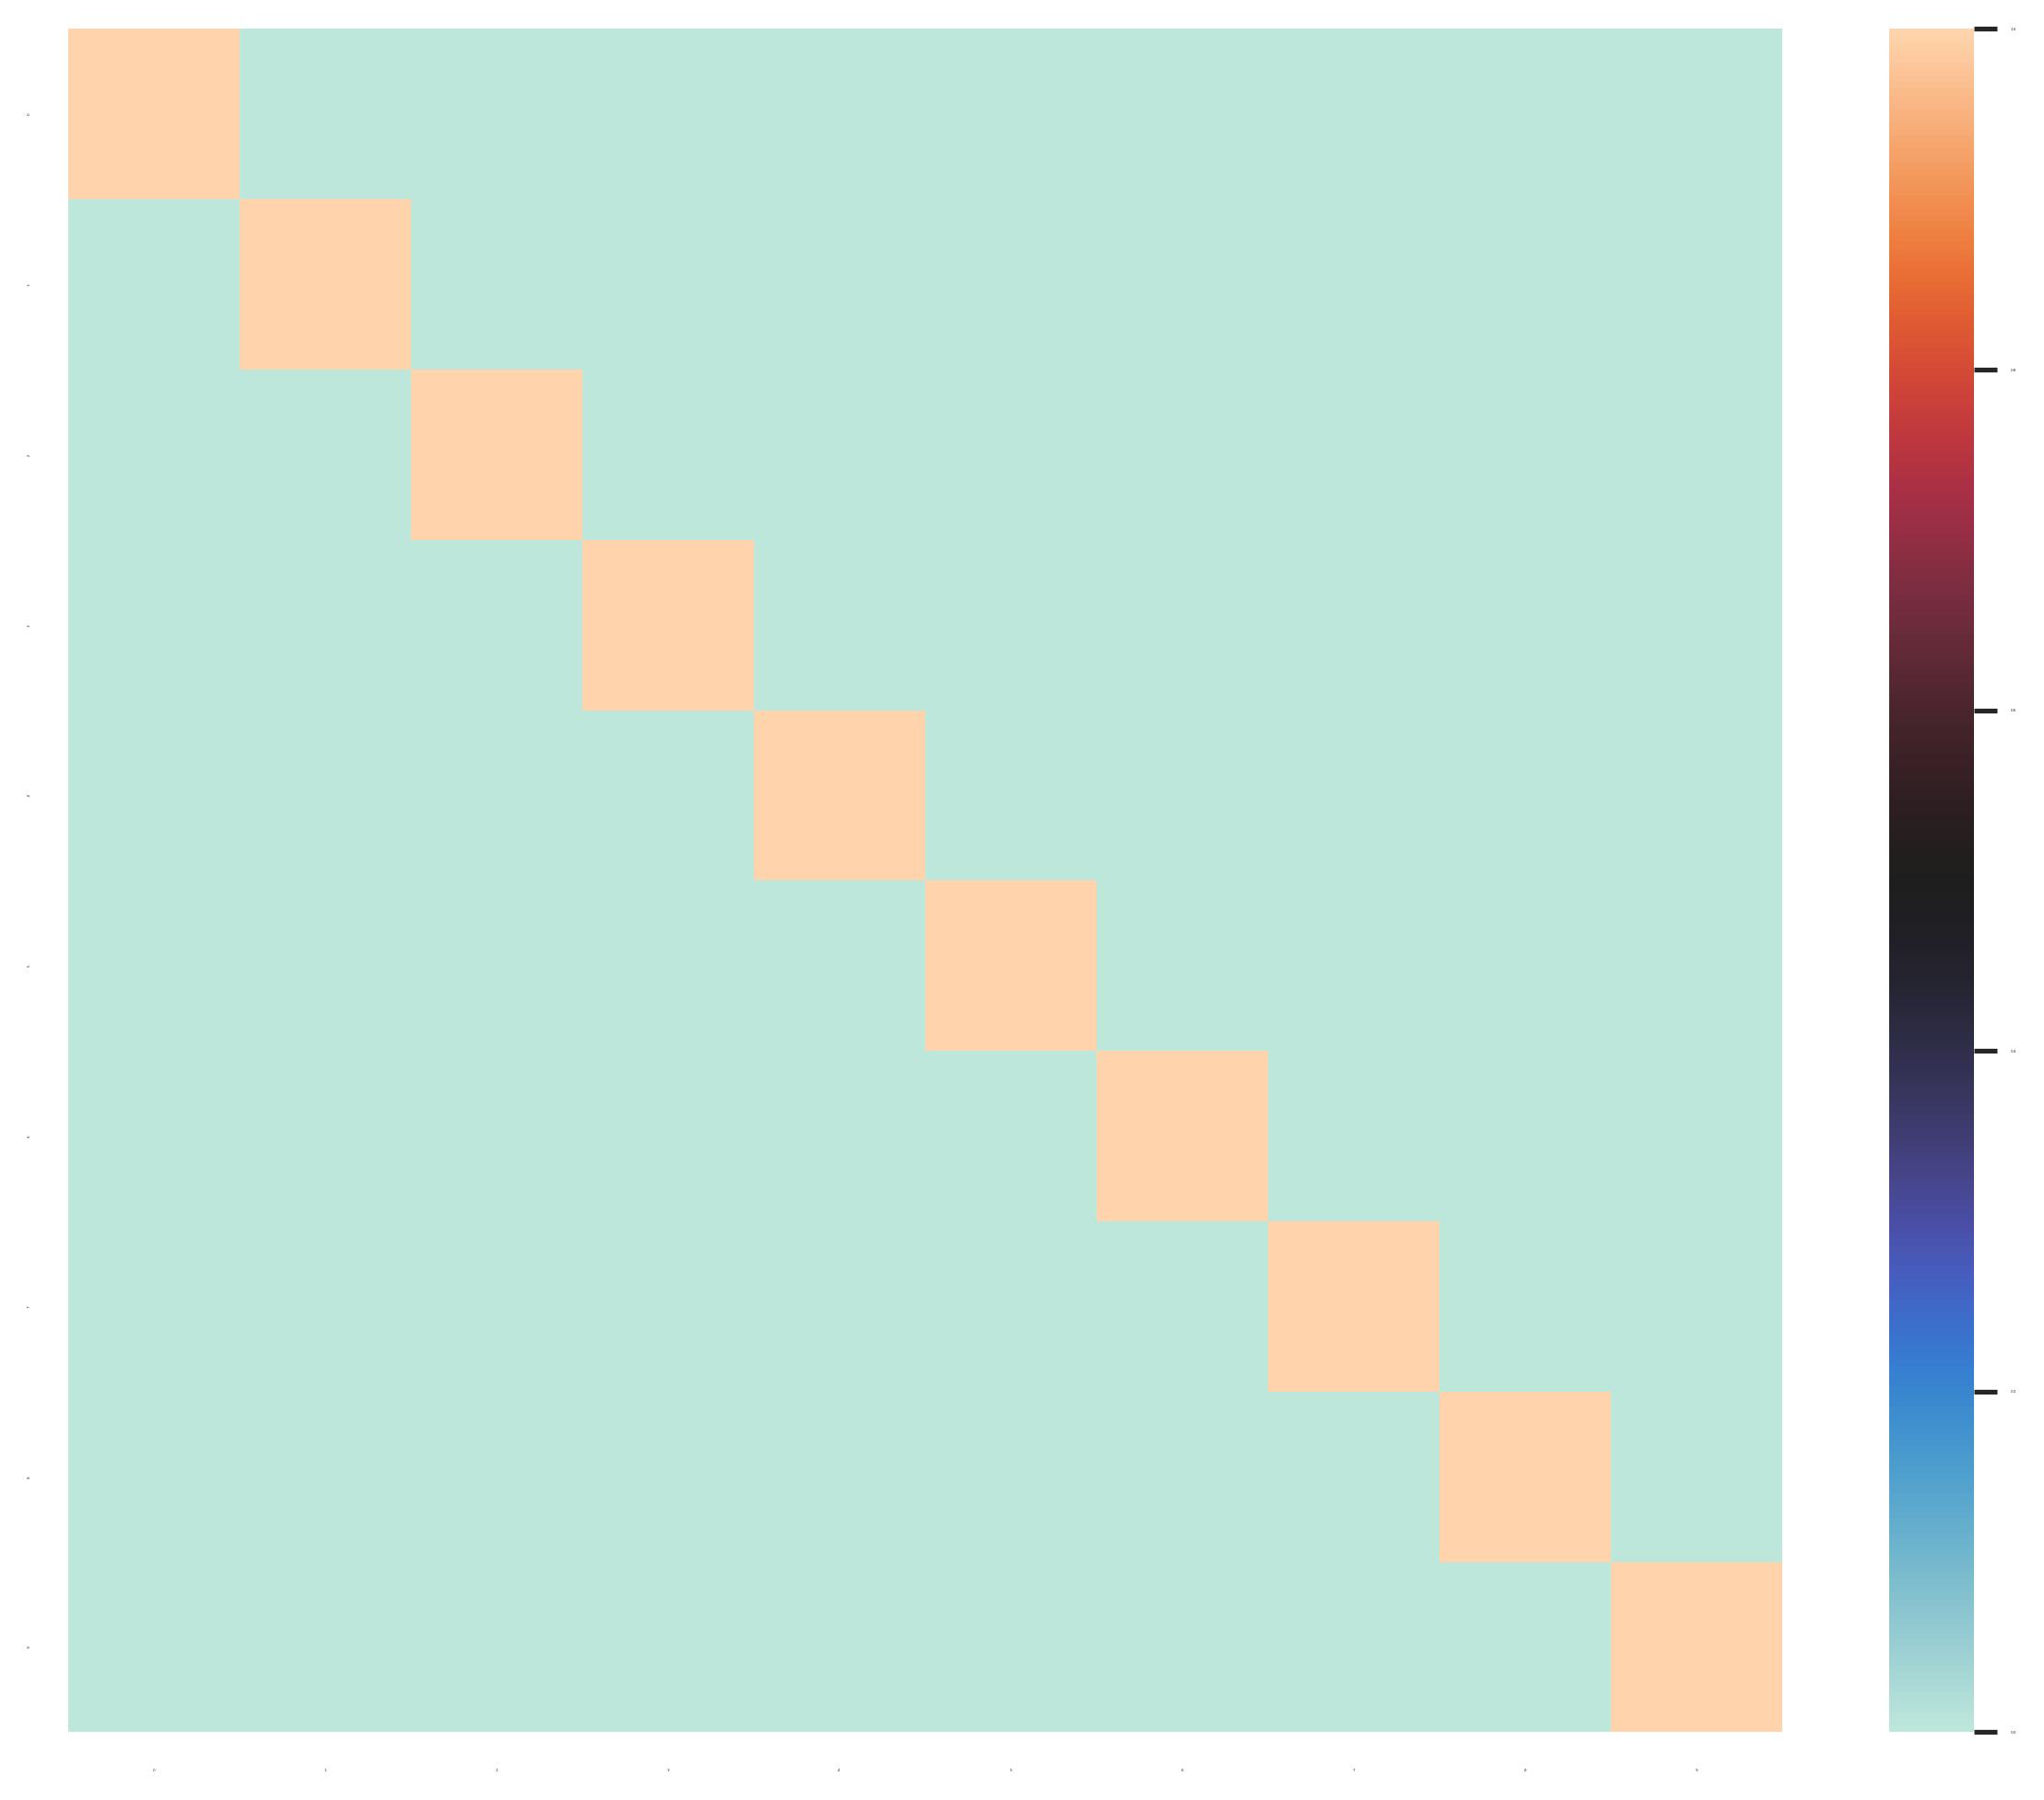

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


cm = confusion_matrix(y_test, y_test_pred, normalize='true')


# Change figure size and increase dpi for better resolution
plt.figure(figsize=(10,8), dpi=300)
# Scale up the size of all text
sns.set(font_scale = 0)

# Plot Confusion Matrix using Seaborn heatmap()
# Parameters:
# fmt = 'd': show numbers as integers. 
ax = sns.heatmap(cm, annot=False,cmap="icefire" )
plt.savefig('confusion_matrix.png')

In [57]:
incorrect_preds = pd.DataFrame([ORD2SIGN[i] for i in y_test_pred[y_test != y_test_pred]],
                               [ORD2SIGN[i] for i in y_test[y_test != y_test_pred]]).reset_index()

incorrect_preds = incorrect_preds.rename(columns={'index':'prediction',0:'label'})
print(len(incorrect_preds))
incorrect_preds.head(100)

0


,prediction
